# Multidimensional scaling for bigBed Jaccard simililarity matrix

In this notebook we will try to come up with some notion of Euclidean distance for the Jaccard similarities we have computed between all of the bigBed pairs. Also it would be cool if we could do some clustering to see if we can recapitulate features of the data. Biclustering

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import MDS
import umap

In [49]:
np.random.seed(0)

Here, `metadata` is a file report TSV from the [ENCODE portal](https://www.encodeproject.org). `data` is a TSV file containing pairs of file IDs and the computed jaccard values.

In [9]:
metadata = pd.read_csv("../data/file_report_2020_4_15_2h_50m.tsv", sep="\t", header=1)
data = pd.read_csv("../jaccard.tsv", sep="\t")

We'll need to add a column corresponding to the file accessions. You can avoid this if you include the accession in the report you download from ENCODE.

In [94]:
metadata["Accession"] = metadata.ID.str.split("/").map(lambda elem: elem[-2])
metadata.set_index("Accession", inplace=True)
metadata.head()

,ID,Dataset,Biological replicates,Biosample name,Target label,Cloud metadata,Biosample ontology
Accession,,,,,,,
ENCFF145CKY,/files/ENCFF145CKY/,/experiments/ENCSR331HPA/,"1,2",GM12878,GABPA,"{'md5sum_base64': 'KU4lHzdxxDMQXy0jPcCFdQ==', ...",/biosample-types/cell_line_EFO_0002784/
ENCFF405KVS,/files/ENCFF405KVS/,/experiments/ENCSR000EGT/,"1,2",K562,IRF1,"{'md5sum_base64': '4UetgEthvZJtWG0SY74a7A==', ...",/biosample-types/cell_line_EFO_0002067/
ENCFF483DQZ,/files/ENCFF483DQZ/,/experiments/ENCSR874HSH/,"1,2",OCI-LY1,H2AFZ,"{'md5sum_base64': 'F1Au9eRLKW1AoUtGTbaObw==', ...",/biosample-types/cell_line_EFO_0005907/
ENCFF749YTS,/files/ENCFF749YTS/,/experiments/ENCSR739IHN/,"1,2",GM12878,TBX21,"{'md5sum_base64': 'U1nk0FgMu7PQkXCEMvuxPA==', ...",/biosample-types/cell_line_EFO_0002784/
ENCFF272FFT,/files/ENCFF272FFT/,/experiments/ENCSR086YIH/,"1,2",MM.1S,H3K4me2,"{'md5sum_base64': 'mwUvruHFGkJpp19Mn3QhMg==', ...",/biosample-types/cell_line_EFO_0005724/


In [10]:
data.head()

,id1,id2,jaccard
0,ENCFF145CKY,ENCFF405KVS,0.02
1,ENCFF145CKY,ENCFF483DQZ,0.00
2,ENCFF145CKY,ENCFF749YTS,0.00
3,ENCFF145CKY,ENCFF272FFT,0.01
4,ENCFF145CKY,ENCFF198STH,0.00


Let's encode the file accessions as integer labels. That way we can use the transform the file IDs into numbers we can directly use to index into the similarity matrix we want to construct. We need to concat the columns because one of the file IDs will be missing from each one.

In [36]:
label_encoder = LabelEncoder()
label_encoder.fit(np.concatenate((data.id1.values, data.id2.values)))

LabelEncoder()

Now we can set the entries of this matrix. Note that we set the indices twice so that the matrix is symmetric. We also set the diagonal manually, since we know that the Jaccard of any set with itself is one.

In [43]:
similarity = np.zeros((metadata.shape[0], metadata.shape[0]))
x_idxs = label_encoder.transform(data.id1.values)
y_idxs = label_encoder.transform(data.id2.values)
similarity[x_idxs, y_idxs] = data.jaccard.values
similarity[y_idxs, x_idxs] = data.jaccard.values
np.fill_diagonal(similarity, 1.)
print(f"similarity matrix is {np.count_nonzero(similarity) / similarity.shape[0] ** 2:.2%} empty")

We'll project our data into 2-D so we can visualize it. `sklearn`'s `MDS` is expecting a dissimilarity matrix, we can convert ours by subtracting the similarity from a matrix of ones.

In [55]:
embedding = MDS(n_components=2, dissimilarity="precomputed")
dissimilarity = np.ones_like(similarity) - similarity
similarity_mds = embedding.fit_transform(dissimilarity)

Let's plot the embedding. We can set the colors to identify specific targets on the plot.

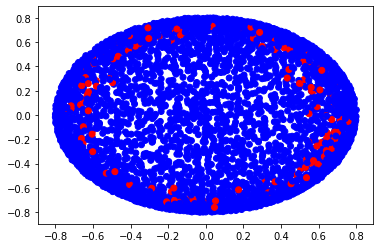

In [97]:
fig, ax = plt.subplots()
label_order = label_encoder.inverse_transform(np.arange(similarity.shape[0]))
colors = ["red"  if metadata.loc[i]["Target label"] == "CTCF" else "blue" for i in label_order]
ax.scatter(similarity_mds[:,0], similarity_mds[:,1], c=colors)

This looks pretty bad. We can also try plotting the UMAP feeding in our precomputed distance matrix: https://github.com/lmcinnes/umap/issues/61

In [65]:
similarity_umap = umap.UMAP(metric="precomputed", unique=True).fit_transform(dissimilarity)

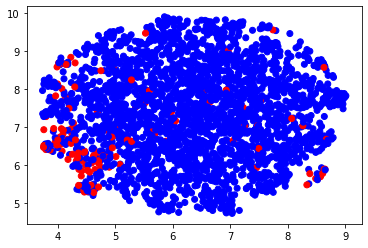

In [98]:
fig, ax = plt.subplots()
ax.scatter(similarity_umap[:,0], similarity_umap[:,1], c=colors)

The UMAP seems to do a better job of localizing the CTCF tracks together. There are likely still sample-specific differences confounding the clustering however.